# Feature-based predictor
This notebook is based on [Andrew Lukyanenko](https://www.kaggle.com/artgor)'s [kernel](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples).

## General information
Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [1]:
import gc
import os
import time
import random
import datetime
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from scipy import stats
from scipy.signal import hilbert, hann, convolve

#from tensorflow import keras
from keras import layers, Sequential, callbacks, backend
from keras.utils import multi_gpu_model
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1, l2

#from tensorflow.keras import layers


from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from utils import freq_from_crossings, freq_from_fft
from features import gpi

Using TensorFlow backend.


In [2]:
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

## Training data

In [3]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000

CPU times: user 1min 24s, sys: 3.36 s, total: 1min 27s
Wall time: 1min 27s


In [4]:
print(f'Train: rows:{train.shape[0]} cols:{train.shape[1]}')

Train: rows:629145480 cols:2


Let's visualize it

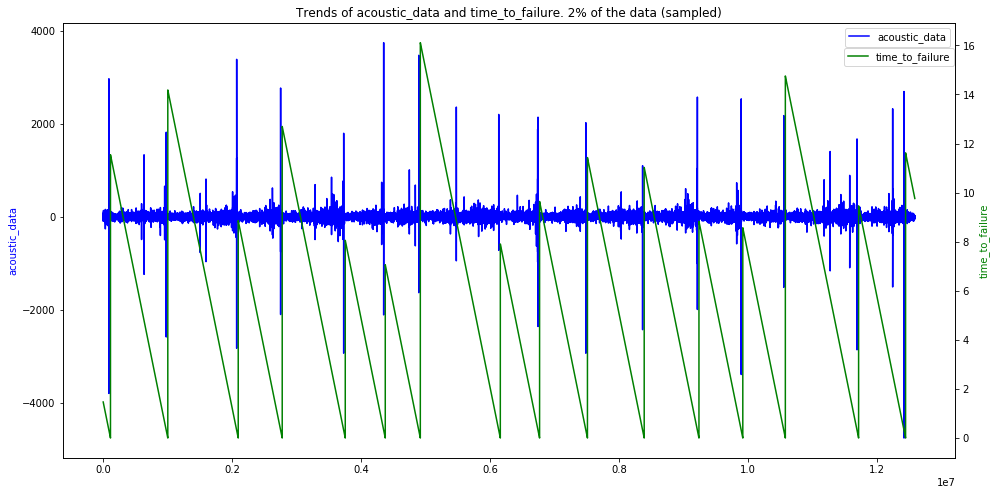

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Trends of acoustic_data and time_to_failure. 2% of the data (sampled)')
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

- We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
- Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;
- I thought that comparing max values of signal in a segment to some threshold value (1000 or 2000) could be useful, but it didn't work;

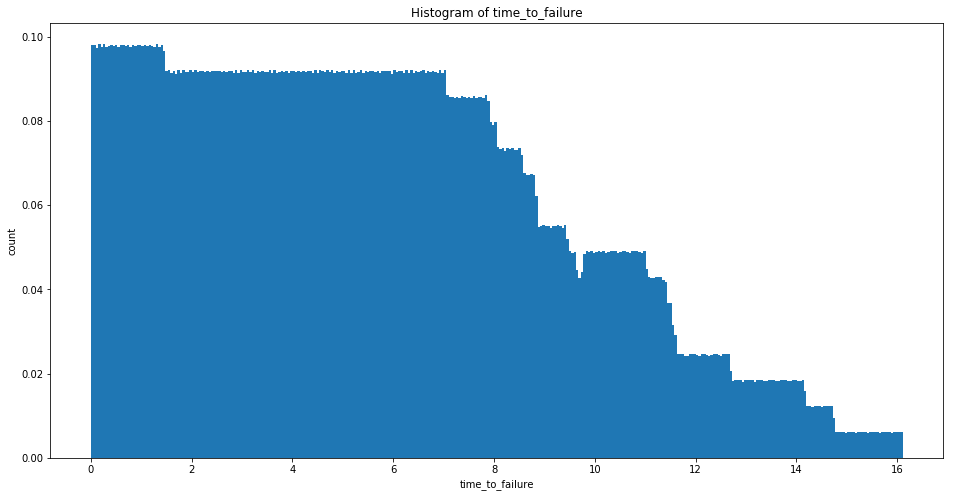

In [6]:
plt.figure(figsize=(16, 8))
plt.hist(train['time_to_failure'].values[::50], bins='auto', density=True)  # arguments are passed to np.histogram
plt.title('Histogram of time_to_failure')
plt.xlabel('time_to_failure')
plt.ylabel('count')
plt.show()

- The time to training is not uniforally distribured on the training set. Resampling could be interesting.

## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [7]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [8]:
def sta_lta_ratio(x, length_sta, length_lta, method='original'):
    if method=='original':
        sta = np.cumsum(x ** 2)
        # Convert to float
        sta = np.require(sta, dtype=np.float)
        # Copy for LTA
        lta = sta.copy()
        # Compute the STA and the LTA
        sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
        sta /= length_sta
        lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
        lta /= length_lta
        # Pad zeros
        sta[:length_lta - 1] = 0
        # Avoid division by zero by setting zero values to tiny float
        dtiny = np.finfo(0.0).tiny
        idx = lta < dtiny
        lta[idx] = dtiny
        ratio = sta / lta
        
    elif method == 'modified':
        x_abs = np.abs(x)
        # Convert to float
        x_abs = np.require(x_abs, dtype=np.float)
        # Compute the STA and the LTA
        sta = np.cumsum(x_abs)
        sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
        sta = sta[length_sta - 1:] / length_sta
        sta = sta[:-(length_lta-length_sta)]
        lta = x_abs.copy()
        lta = np.cumsum(lta)
        lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
        lta = lta[length_lta - 1:] / length_lta
        ratio = sta / lta

    return ratio

In [9]:
def change_rate(x, method='original'):
    if method == 'original':
        rate = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    if method == 'modified':
        change = (np.diff(x) / x[:-1]).values
        change = change[np.nonzero(change)[0]]
        change = change[~np.isnan(change)]
        change = change[change != -np.inf]
        change = change[change != np.inf]
        rate = np.mean(change)
    return rate

In [10]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    # Generic stats
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_diff'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_abs_diff'] = np.mean(np.abs(np.diff(xc)))
    X.loc[seg_id, 'mean_change_rate'] = change_rate(xc, method='original')
    X.loc[seg_id, 'mean_change_rate_v2'] = change_rate(xc, method='modified')
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    # Classical stats by segment
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = change_rate(xc[:50000], method='original')
    X.loc[seg_id, 'mean_change_rate_last_50000'] = change_rate(xc[-50000:], method='original')
    X.loc[seg_id, 'mean_change_rate_first_10000'] = change_rate(xc[:10000], method='original')
    X.loc[seg_id, 'mean_change_rate_last_10000'] = change_rate(xc[-10000:], method='original')

    X.loc[seg_id, 'mean_change_rate_first_50000_v2'] = change_rate(xc[:50000], method='modified')
    X.loc[seg_id, 'mean_change_rate_last_50000_v2'] = change_rate(xc[-50000:], method='modified')
    X.loc[seg_id, 'mean_change_rate_first_10000_v2'] = change_rate(xc[:10000], method='modified')
    X.loc[seg_id, 'mean_change_rate_last_10000_v2'] = change_rate(xc[-10000:], method='modified')

    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()    
    
    sta_lta_method = 'original'
    classic_sta_lta1 = sta_lta_ratio(xc, 500, 10000, method=sta_lta_method)
    classic_sta_lta2 = sta_lta_ratio(xc, 5000, 100000, method=sta_lta_method)
    classic_sta_lta3 = sta_lta_ratio(xc, 3333, 6666, method=sta_lta_method)
    classic_sta_lta4 = sta_lta_ratio(xc, 10000, 25000, method=sta_lta_method)
    classic_sta_lta5 = sta_lta_ratio(xc, 50, 1000, method=sta_lta_method)
    classic_sta_lta6 = sta_lta_ratio(xc, 100, 5000, method=sta_lta_method)
    classic_sta_lta7 = sta_lta_ratio(xc, 333, 666, method=sta_lta_method)
    classic_sta_lta8 = sta_lta_ratio(xc, 4000, 10000, method=sta_lta_method)
    
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta1.mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta2.mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta3.mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta4.mean()
    X.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta5.mean()
    X.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta6.mean()
    X.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta7.mean()
    X.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta8.mean()

    X.loc[seg_id, 'classic_sta_lta1_q95'] = np.quantile(classic_sta_lta1, 0.95)
    X.loc[seg_id, 'classic_sta_lta2_q95'] = np.quantile(classic_sta_lta2, 0.95)
    X.loc[seg_id, 'classic_sta_lta3_q95'] = np.quantile(classic_sta_lta3, 0.95)
    X.loc[seg_id, 'classic_sta_lta4_q95'] = np.quantile(classic_sta_lta4, 0.95)
    X.loc[seg_id, 'classic_sta_lta5_q95'] = np.quantile(classic_sta_lta5, 0.95)
    X.loc[seg_id, 'classic_sta_lta6_q95'] = np.quantile(classic_sta_lta6, 0.95)
    X.loc[seg_id, 'classic_sta_lta7_q95'] = np.quantile(classic_sta_lta7, 0.95)
    X.loc[seg_id, 'classic_sta_lta8_q95'] = np.quantile(classic_sta_lta8, 0.95)   

    X.loc[seg_id, 'classic_sta_lta1_q05'] = np.quantile(classic_sta_lta1, 0.05)
    X.loc[seg_id, 'classic_sta_lta2_q05'] = np.quantile(classic_sta_lta2, 0.05)
    X.loc[seg_id, 'classic_sta_lta3_q05'] = np.quantile(classic_sta_lta3, 0.05)
    X.loc[seg_id, 'classic_sta_lta4_q05'] = np.quantile(classic_sta_lta4, 0.05)
    X.loc[seg_id, 'classic_sta_lta5_q05'] = np.quantile(classic_sta_lta5, 0.05)
    X.loc[seg_id, 'classic_sta_lta6_q05'] = np.quantile(classic_sta_lta6, 0.05)
    X.loc[seg_id, 'classic_sta_lta7_q05'] = np.quantile(classic_sta_lta7, 0.05)
    X.loc[seg_id, 'classic_sta_lta8_q05'] = np.quantile(classic_sta_lta8, 0.05)

    sta_lta_method = 'modified'
    classic_sta_lta1 = sta_lta_ratio(xc, 500, 10000, method=sta_lta_method)
    classic_sta_lta2 = sta_lta_ratio(xc, 5000, 100000, method=sta_lta_method)
    classic_sta_lta3 = sta_lta_ratio(xc, 3333, 6666, method=sta_lta_method)
    classic_sta_lta4 = sta_lta_ratio(xc, 10000, 25000, method=sta_lta_method)
    classic_sta_lta5 = sta_lta_ratio(xc, 50, 1000, method=sta_lta_method)
    classic_sta_lta6 = sta_lta_ratio(xc, 100, 5000, method=sta_lta_method)
    classic_sta_lta7 = sta_lta_ratio(xc, 333, 666, method=sta_lta_method)
    classic_sta_lta8 = sta_lta_ratio(xc, 4000, 10000, method=sta_lta_method)
    
    X.loc[seg_id, 'modified_sta_lta1_mean'] = classic_sta_lta1.mean()
    X.loc[seg_id, 'modified_sta_lta2_mean'] = classic_sta_lta2.mean()
    X.loc[seg_id, 'modified_sta_lta3_mean'] = classic_sta_lta3.mean()
    X.loc[seg_id, 'modified_sta_lta4_mean'] = classic_sta_lta4.mean()
    X.loc[seg_id, 'modified_sta_lta5_mean'] = classic_sta_lta5.mean()
    X.loc[seg_id, 'modified_sta_lta6_mean'] = classic_sta_lta6.mean()
    X.loc[seg_id, 'modified_sta_lta7_mean'] = classic_sta_lta7.mean()
    X.loc[seg_id, 'modified_sta_lta8_mean'] = classic_sta_lta8.mean()

    X.loc[seg_id, 'modified_sta_lta1_q95'] = np.quantile(classic_sta_lta1, 0.95)
    X.loc[seg_id, 'modified_sta_lta2_q95'] = np.quantile(classic_sta_lta2, 0.95)
    X.loc[seg_id, 'modified_sta_lta3_q95'] = np.quantile(classic_sta_lta3, 0.95)
    X.loc[seg_id, 'modified_sta_lta4_q95'] = np.quantile(classic_sta_lta4, 0.95)
    X.loc[seg_id, 'modified_sta_lta5_q95'] = np.quantile(classic_sta_lta5, 0.95)
    X.loc[seg_id, 'modified_sta_lta6_q95'] = np.quantile(classic_sta_lta6, 0.95)
    X.loc[seg_id, 'modified_sta_lta7_q95'] = np.quantile(classic_sta_lta7, 0.95)
    X.loc[seg_id, 'modified_sta_lta8_q95'] = np.quantile(classic_sta_lta8, 0.95)   

    X.loc[seg_id, 'modified_sta_lta1_q05'] = np.quantile(classic_sta_lta1, 0.05)
    X.loc[seg_id, 'modified_sta_lta2_q05'] = np.quantile(classic_sta_lta2, 0.05)
    X.loc[seg_id, 'modified_sta_lta3_q05'] = np.quantile(classic_sta_lta3, 0.05)
    X.loc[seg_id, 'modified_sta_lta4_q05'] = np.quantile(classic_sta_lta4, 0.05)
    X.loc[seg_id, 'modified_sta_lta5_q05'] = np.quantile(classic_sta_lta5, 0.05)
    X.loc[seg_id, 'modified_sta_lta6_q05'] = np.quantile(classic_sta_lta6, 0.05)
    X.loc[seg_id, 'modified_sta_lta7_q05'] = np.quantile(classic_sta_lta7, 0.05)
    X.loc[seg_id, 'modified_sta_lta8_q05'] = np.quantile(classic_sta_lta8, 0.05)

    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_30000_mean'] = xc.rolling(window=30000).mean().mean(skipna=True)

    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = ewma(xc, span=300).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_6000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=30000).mean().mean(skipna=True)

    # rdg: TODO it seems a parameter to tune
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id, 'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                              + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                             - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id, 'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                              + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                             - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc, 0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc, 0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)

    X.loc[seg_id, 'freq_cross_first_50000'] = freq_from_crossings(xc.values[:50000], fs)
    X.loc[seg_id, 'freq_cross_last_50000'] = freq_from_crossings(xc.values[-50000:], fs)
    X.loc[seg_id, 'freq_cross_first_10000'] = freq_from_crossings(xc.values[:10000], fs)
    X.loc[seg_id, 'freq_cross_last_10000'] = freq_from_crossings(xc.values[-10000:], fs)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_std)))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = change_rate(pd.Series(x_roll_std), 
                                                                               method='original')
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows) + 'v2'] = change_rate(pd.Series(x_roll_std),
                                                                                      method='modified')
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_mean)))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = change_rate(pd.Series(x_roll_mean),
                                                                               method = 'original')
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows) + '_v2'] = change_rate(pd.Series(x_roll_mean),
                                                                                       method = 'modified')
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

## Sampling the training set
Since the testign set is build of sequences of 150.000 samples, let's chop the training set on comparable chunks. 

In [11]:
# Create a training file with simple derived features
segment_size = 150000

In [12]:
def generate_segment_start_ids(sampling_method):
    if sampling_method == 'uniform':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        segment_start_ids = [i * segment_size for i in range(num_segments_training)]
    elif sampling_method == 'uniform_no_jump':
        # With this approach we obtain 4178 segments (99.5% of 'uniform')
        already_sampled = np.full(train.shape[0], False)
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        for i in range(num_segments_training):
            idx = i * segment_size
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    elif sampling_method == 'random_no_jump':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size)) #arbitrary choice
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        while num_segments_training != num_good_segments_found:
            # Generate a random sampling position
            idx = random.randint(0, train.shape[0] - segment_size - 1)
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    else:
        raise NameError('Method does not exist')
    return segment_start_ids

Currently, we have two strategies implemented.
- Uniform sampling: Here the training set is built from consecutive chunks of data. No special care is taken into what's the content of each segment.
- Uniform sampling with rejection: Here the training set is built from consecutive chunks of data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value.
- Random sampling with rejection: Here the training set is built from sampling randomly the data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value. The segments will most likely overlap.

Let's visualize what happens to the distribution of the `time_to_failure` on teh different samplign strategies:

Generating uniformly sampled training set
Generating uniformly sampled training set excluding discontinuities in time_to_failure.
Rejected candidate segment since max_jump=11.54000473022461
Rejected candidate segment since max_jump=14.17990493774414
Rejected candidate segment since max_jump=8.855904579162598
Rejected candidate segment since max_jump=12.692904472351074
Rejected candidate segment since max_jump=8.05490493774414
Rejected candidate segment since max_jump=7.0579047203063965
Rejected candidate segment since max_jump=16.106904983520508
Rejected candidate segment since max_jump=7.904904365539551
Rejected candidate segment since max_jump=9.6369047164917
Rejected candidate segment since max_jump=11.425904273986816
Rejected candidate segment since max_jump=11.024004936218262
Rejected candidate segment since max_jump=8.828004837036133
Rejected candidate segment since max_jump=8.56590461730957
Rejected candidate segment since max_jump=14.750904083251953
Rejected candidate segment s

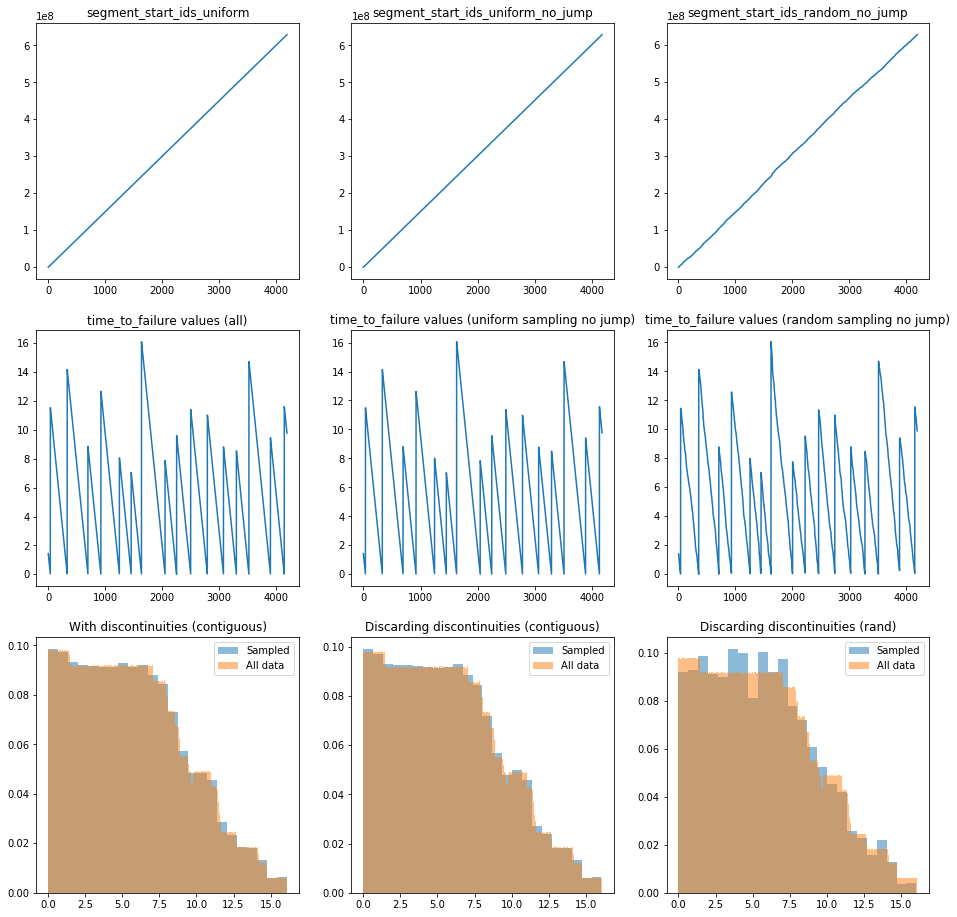

In [13]:
print(f'Generating uniformly sampled training set')
segment_start_ids_uniform = generate_segment_start_ids('uniform')

print(f'Generating uniformly sampled training set excluding discontinuities in time_to_failure.')
segment_start_ids_uniform_no_jump = generate_segment_start_ids('uniform_no_jump')

print(f'Generating randomly sampled training set excluding discontinuities in time_to_failure.')
print(f'This method may yield overlaping segments')
segment_start_ids_random_no_jump = generate_segment_start_ids('random_no_jump')


y_tr_samples_uniform = train['time_to_failure'].values[np.array(
    segment_start_ids_uniform) + segment_size - 1]
y_tr_samples_uniform_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_uniform_no_jump) + segment_size - 1]
y_tr_samples_random_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_random_no_jump) + segment_size - 1]

plt.subplots(figsize=(16, 16))
plt.subplot(3, 3, 1)
plt.plot(segment_start_ids_uniform)
plt.title('segment_start_ids_uniform')
plt.subplot(3, 3, 2)
plt.plot(segment_start_ids_uniform_no_jump)
plt.title('segment_start_ids_uniform_no_jump')
plt.subplot(3, 3, 3)
plt.plot(segment_start_ids_random_no_jump)
plt.title('segment_start_ids_random_no_jump')

plt.subplot(3, 3, 4)
plt.plot(y_tr_samples_uniform)
plt.title('time_to_failure values (all)')
plt.subplot(3, 3, 5)
plt.plot(y_tr_samples_uniform_no_jump)
plt.title('time_to_failure values (uniform sampling no jump)')
plt.subplot(3, 3, 6)
plt.plot(y_tr_samples_random_no_jump)
plt.title('time_to_failure values (random sampling no jump)')

plt.subplot(3, 3, 7)
plt.hist(y_tr_samples_uniform, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('With discontinuities (contiguous)')
plt.legend(['Sampled', 'All data'])

plt.subplot(3, 3, 8)
plt.hist(y_tr_samples_uniform_no_jump, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('Discarding discontinuities (contiguous)')
plt.legend(['Sampled', 'All data'])

plt.subplot(3, 3, 9)
plt.hist(y_tr_samples_random_no_jump, bins='auto', alpha=0.5, density=True)
plt.title('Discarding discontinuities (rand)')
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.legend(['Sampled', 'All data'])
plt.show()

del segment_start_ids_uniform
del segment_start_ids_uniform_no_jump
del segment_start_ids_random_no_jump
del y_tr_samples_uniform
del y_tr_samples_uniform_no_jump
del y_tr_samples_random_no_jump

Finally, we choose one sampling method (`uniform`) and run with it

In [14]:
segment_start_ids = generate_segment_start_ids('uniform_no_jump')

Rejected candidate segment since max_jump=11.54000473022461
Rejected candidate segment since max_jump=14.17990493774414
Rejected candidate segment since max_jump=8.855904579162598
Rejected candidate segment since max_jump=12.692904472351074
Rejected candidate segment since max_jump=8.05490493774414
Rejected candidate segment since max_jump=7.0579047203063965
Rejected candidate segment since max_jump=16.106904983520508
Rejected candidate segment since max_jump=7.904904365539551
Rejected candidate segment since max_jump=9.6369047164917
Rejected candidate segment since max_jump=11.425904273986816
Rejected candidate segment since max_jump=11.024004936218262
Rejected candidate segment since max_jump=8.828004837036133
Rejected candidate segment since max_jump=8.56590461730957
Rejected candidate segment since max_jump=14.750904083251953
Rejected candidate segment since max_jump=9.458905220031738
Rejected candidate segment since max_jump=11.61800479888916


In [15]:
X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])

Compute all features for all segments (WARNING: it takes time)

In [16]:
for idx in tqdm_notebook(range(len(segment_start_ids))):        
    seg_id = segment_start_ids[idx]
    seg = train.iloc[seg_id:seg_id + segment_size]
    create_features(idx, seg, X_tr)
    y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]

HBox(children=(IntProgress(value=0, max=4178), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

Let's take a look of how some of these features look like

In [ ]:
plt.subplots(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    ax1 = plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'])
    plt.grid(False)

Sometimes, there are features that exploded, which show as `np.inf` in the array. Let's just replace them by the mean values. TODO: check if this is the appropiate strategy. 

In [ ]:
# Sanity check
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

## Reading test data

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

In [ ]:
plt.figure(figsize=(22, 16))
for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

In [ ]:
# Sanity check
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

## Scale data

In [ ]:
#scaler = StandardScaler()
#scaler.fit(X_tr)
#X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
#Only real difference is scaling the lot in one go rather than scling train and then using this to scale test
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [ ]:
def grid_search_cv(estimator, grid, features, target, num_folds):
    """Return the best hyperparameters combination in grid."""
    t0 = time.time()
    reg = GridSearchCV(estimator, grid, cv=num_folds, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=10)
    reg.fit(features, target)
    
    t0 = time.time() - t0
    print("Best CV score: {:.4f}, time: {:.1f}s".format(-reg.best_score_, t0))
    print(reg.best_params_)
    return reg.best_params_, reg.cv_results_

In [ ]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'nn':
            model = Sequential()
            model.add(layers.Dense(1024, input_dim=216, activation=tf.nn.relu))
            model.add(layers.Dropout(0.8))
            model.add(layers.Dense(256, activation=tf.nn.relu))
            model.add(layers.Dropout(0.8))
            model.add(layers.Dense(256, activation=tf.nn.relu))
            model.add(layers.Dropout(0.8))
            model.add(layers.Dense(16, activation=tf.nn.relu))
            model.add(layers.Dense(1))

            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
            EPOCHS = 1000
            early_stop = callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

            history = model.fit(
                X_train,
                y_train,
                epochs=EPOCHS,
                validation_data = (X_valid, y_valid), 
                verbose=0,
                callbacks=[early_stop, PrintDot()])
            hist = pd.DataFrame(history.history)
            val_score = hist['val_mean_absolute_error'].iloc[-1]
            print(f'val_score={val_score}')
            plot_history(history)
        
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            y_pred = model.predict(X_test).reshape(-1,)

            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = 32)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=2000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if model_type == 'gdi':
            y_pred_valid = gpi(X_valid).values
            y_pred = gpi(X_test).values
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance['importance'] /= n_fold
        return oof, prediction, np.mean(scores), np.std(scores), feature_importance
    else:
        return oof, prediction, np.mean(scores), np.std(scores)


# Feature selection

In [693]:
n_fold_features = 5
folds_features = KFold(n_splits=n_fold_features, shuffle=True, random_state=11)

Fold 0 started at Mon Mar 25 07:22:18 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1139]	training's l1: 1.55799	valid_1's l1: 2.04822
Fold 1 started at Mon Mar 25 07:22:30 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1282]	training's l1: 1.49958	valid_1's l1: 2.03082
Fold 2 started at Mon Mar 25 07:22:43 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1360]	training's l1: 1.44243	valid_1's l1: 2.13248
Fold 3 started at Mon Mar 25 07:22:55 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[989]	training's l1: 1.65693	valid_1's l1: 1.88893
Fold 4 started at Mon Mar 25 07:23:06 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2402]	training's l1: 1.12554	valid_1's l1: 2.05148
CV mean score: 2.0304, std: 0.0

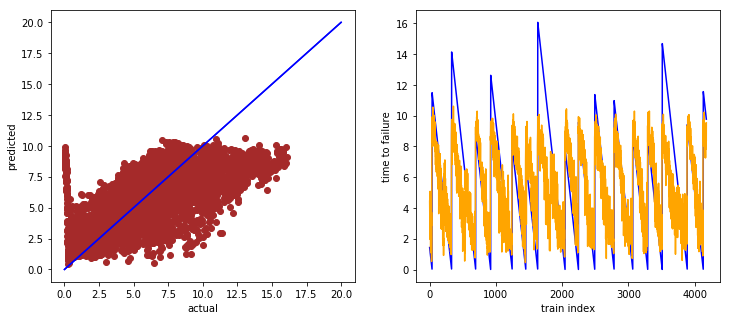

In [694]:
params = {
    'num_leaves': 54,
    'min_data_in_leaf': 79,
    'objective': 'huber',
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'bagging_freq': 5,
    'bagging_fraction': 0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'verbosity': -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501
}
oof_lgb, prediction_lgb, score_mean_lgb, score_std_lgb, feature_importance_lgb = train_model(
    X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_features,
    params=params,
    model_type='lgb',
    show_scatter=True)

After building a simple mode, let's see which are the important features

In [695]:
max_num_features = 216
cols_feat = (feature_importance_lgb[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:max_num_features].index)
best_features = feature_importance_lgb.loc[feature_importance_lgb.feature.isin(cols_feat)]

Text(0.5,1,'LightGBM Features (averaged over folds)')

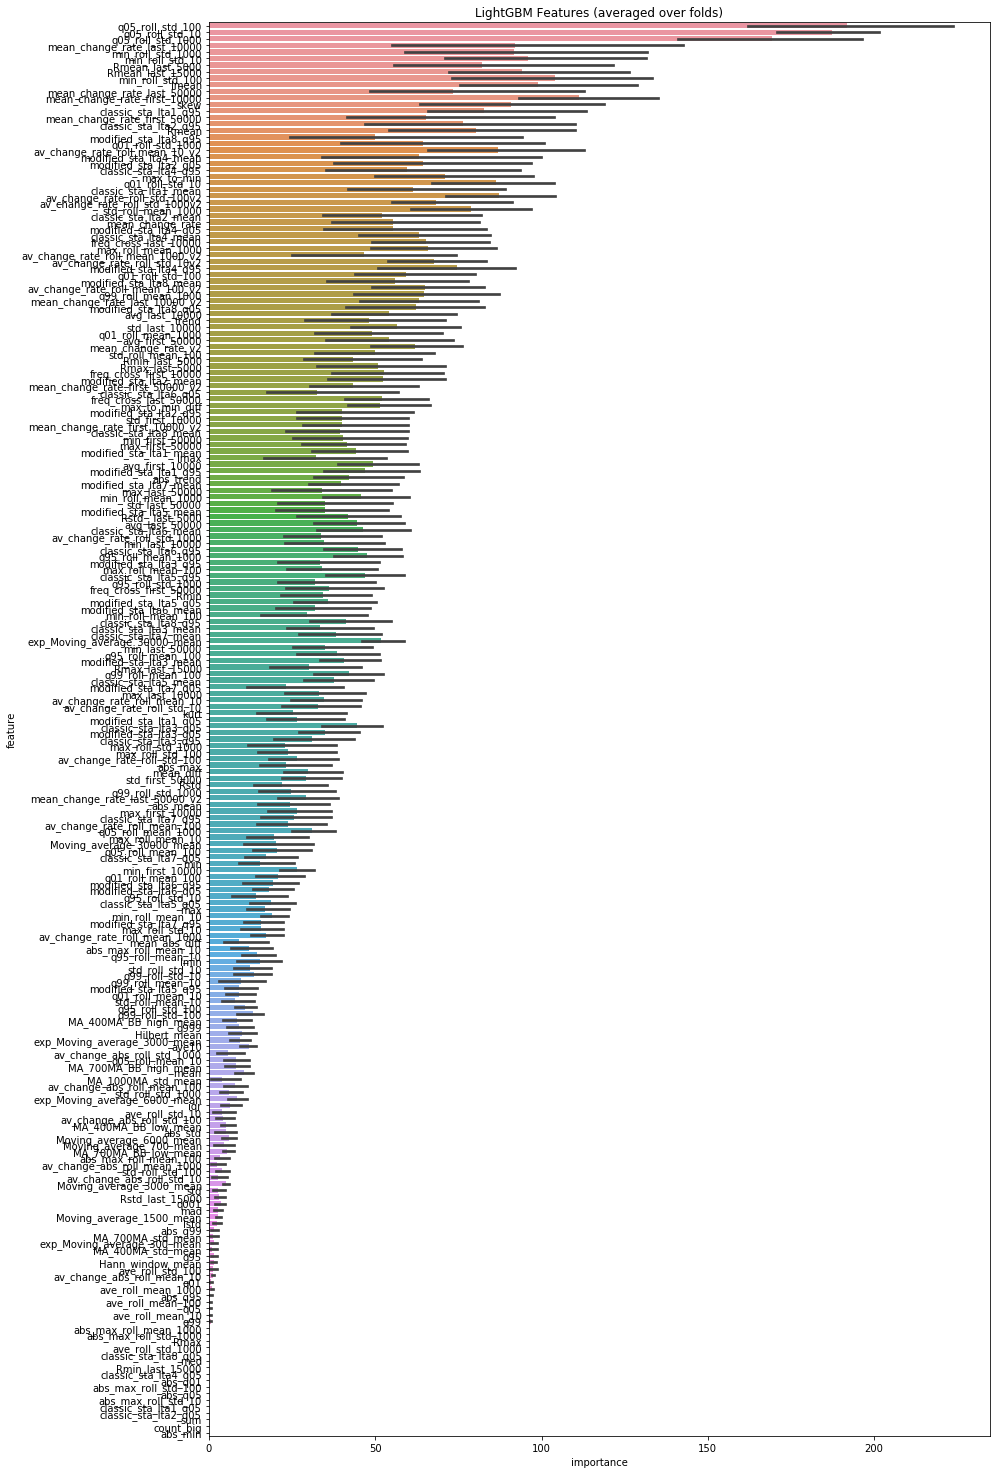

In [696]:
plt.figure(figsize=(14,26))
sns.barplot(x='importance', y='feature', data=feature_importance_lgb.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (averaged over folds)')

TODO: Clearly, come features do not seem to bring any value to the mix. Let's visualize it carefully in case there is something wrong with them (or even if they make sense).

In [697]:
best_features_list = cols_feat.tolist()
X_train_scaled_best = X_train_scaled[best_features_list]
X_test_scaled_best = X_test_scaled[best_features_list]
n_fold_models = 5
folds_models = KFold(n_splits=n_fold_models, shuffle=True, random_state=11)

## Models
Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

Let's first search for the best parameters for this model. It is not possible to use `GridSearchCV` with early stopping (lightgbm), so I am using a custom function for random search.

In [280]:
fixed_params = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'n_estimators': 50000,
    'metric': 'mae',
    'bagging_seed': 11
}

In [281]:
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)
}

In [282]:
grid_size = 1
for param in param_grid:
    grid_size *= len(param_grid[param])
print(f'The search grid has {grid_size} elements')

The search grid has 16800000 elements


In [303]:
best_score = 9999
dataset = lgb.Dataset(X_train_scaled_best, label=y_tr)  # no need to scale features

scores_val_mean = []
scores_val_std = []
for i in tqdm_notebook(range(200)):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params,
                    dataset,
                    nfold=n_fold_models,
                    early_stopping_rounds=200,
                    stratified=False)
    
    print(f"Iteration {i} finished with mae={result['l1-mean'][-1]:.4f} and std={result['l1-stdv'][-1]:.4f}")
    scores_val_mean.append(result['l1-mean'][-1])
    scores_val_std.append(result['l1-stdv'][-1])
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

Iteration 0 finished with mae=2.0352 and std=0.0178
Iteration 1 finished with mae=2.0273 and std=0.0179
Iteration 2 finished with mae=2.0697 and std=0.0204
Iteration 3 finished with mae=2.0356 and std=0.0178
Iteration 4 finished with mae=2.0303 and std=0.0190
Iteration 5 finished with mae=2.0341 and std=0.0166
Iteration 6 finished with mae=2.0480 and std=0.0221
Iteration 7 finished with mae=2.0266 and std=0.0147
Iteration 8 finished with mae=2.0275 and std=0.0196
Iteration 9 finished with mae=2.0295 and std=0.0185
Iteration 10 finished with mae=2.0277 and std=0.0182
Iteration 11 finished with mae=2.0298 and std=0.0183
Iteration 12 finished with mae=2.0439 and std=0.0154
Iteration 13 finished with mae=2.0251 and std=0.0169
Iteration 14 finished with mae=2.0397 and std=0.0167
Iteration 15 finished with mae=2.0337 and std=0.0192
Iteration 16 finished with mae=2.0371 and std=0.0171
Iteration 17 finished with mae=2.0439 and std=0.0180
Iteration 18 finished with mae=2.0477 and std=0.0167
Ite

Iteration 154 finished with mae=2.0262 and std=0.0160
Iteration 155 finished with mae=2.0274 and std=0.0177
Iteration 156 finished with mae=2.0478 and std=0.0125
Iteration 157 finished with mae=2.0503 and std=0.0148
Iteration 158 finished with mae=2.0239 and std=0.0168
Iteration 159 finished with mae=2.0597 and std=0.0313
Iteration 160 finished with mae=2.0396 and std=0.0175
Iteration 161 finished with mae=2.0258 and std=0.0154
Iteration 162 finished with mae=2.0426 and std=0.0189
Iteration 163 finished with mae=2.0474 and std=0.0178
Iteration 164 finished with mae=2.0309 and std=0.0171
Iteration 165 finished with mae=2.0362 and std=0.0157
Iteration 166 finished with mae=2.0276 and std=0.0153
Iteration 167 finished with mae=2.0393 and std=0.0155
Iteration 168 finished with mae=2.0344 and std=0.0246
Iteration 169 finished with mae=2.0425 and std=0.0199
Iteration 170 finished with mae=2.0333 and std=0.0176
Iteration 171 finished with mae=2.0245 and std=0.0181
Iteration 172 finished with 

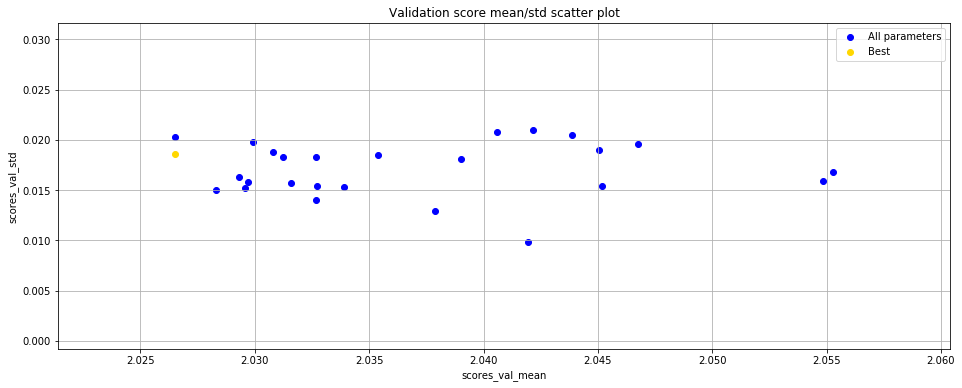

In [302]:
plt.figure(figsize=(16, 6))
plt.scatter(scores_val_mean, scores_val_std, color='blue')
plt.scatter(best_score, best_score_std, color='gold')
plt.xlabel('scores_val_mean')
plt.ylabel('scores_val_std')
plt.title('Validation score mean/std scatter plot')
plt.grid()
plt.legend(['All parameters', 'Best'])
plt.show()

In [294]:
print(f"best_score={best_score}")

best_score=2.0265126875699173


In [295]:
best_params

{'bagging_fraction': 0.7166666666666667,
 'bagging_freq': 3,
 'bagging_seed': 11,
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 6,
 'metric': 'mae',
 'min_data_in_leaf': 100,
 'n_estimators': 50000,
 'num_leaves': 8,
 'objective': 'huber',
 'random_seed': 19,
 'reg_alpha': 0.19444444444444445,
 'reg_lambda': 0.8555555555555555,
 'verbosity': -1}

Fold 0 started at Mon Mar 25 07:23:29 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1134]	training's l1: 1.87472	valid_1's l1: 2.03273
Fold 1 started at Mon Mar 25 07:23:34 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3048]	training's l1: 1.64012	valid_1's l1: 2.02576
Fold 2 started at Mon Mar 25 07:23:41 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1644]	training's l1: 1.77649	valid_1's l1: 2.12417
Fold 3 started at Mon Mar 25 07:23:46 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1110]	training's l1: 1.91609	valid_1's l1: 1.88727
Fold 4 started at Mon Mar 25 07:23:51 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3050]	training's l1: 1.63816	valid_1's l1: 2.05183
CV mean score: 2.0244, std: 0.

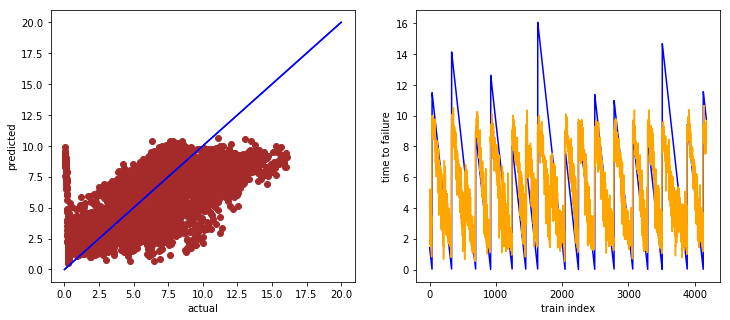

In [698]:
params = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 8, #54,
    'min_data_in_leaf': 100, #79,
    'max_depth': 6, #-1,
    'learning_rate': 0.01,
    'bagging_freq': 3, #5,
    'bagging_fraction': 0.7166666666666667, #0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'reg_alpha': 0.19444444444444445, #0.1302650970728192,
    'reg_lambda': 0.8555555555555555 #0.3603427518866501
}
oof_lgb, prediction_lgb, score_mean_lgb, score_std_lgb, feature_importance = train_model(X=X_train_scaled_best,
                                                                                         X_test=X_test_scaled_best,
                                                                                         y=y_tr,
                                                                                         folds=folds_models,
                                                                                         params=params,
                                                                                         model_type='lgb',
                                                                                         show_scatter=True)

### XGBoost (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

Let's first search for the best parameters for this model. It is not possible to use `GridSearchCV` with early stopping, so I am making my own gird search.

In [207]:
fixed_params = {
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}

In [208]:
param_grid = {
    'eta': [0.01, 0.015, 0.02, 0.025, 0.03, 0.1, 1, 5, 10], #Andrew uses 0.03
    'max_depth': [2, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128],
    'subsample': [0.1, 0.25, 0.5, 0.75, 0.9]
}

In [209]:
grid_size = 1
for param in param_grid:
    grid_size *= len(param_grid[param])
print(f'The search grid has {grid_size} elements')

The search grid has 540 elements


Random search on the parameter grid.

In [214]:
best_score = 9999

dataset = xgb.DMatrix(data=X_train_scaled_best, label=y_tr, feature_names=X_train_scaled_best.columns)
scores_val_mean = []
scores_val_std = []
for i in tqdm_notebook(range(500)):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = xgb.cv(params,
                    dataset,
                    nfold=n_fold_models,
                    num_boost_round=20000,
                    early_stopping_rounds=200,
                    stratified=False)
    
    print(f"Iteration {i} finished with mae={result['test-mae-mean'].iloc[-1]:.4f} and std={result['test-mae-std'].iloc[-1]:.4f}")
    scores_val_mean.append(result['test-mae-mean'].iloc[-1])
    scores_val_std.append(result['test-mae-std'].iloc[-1])
          
    if result['test-mae-mean'].iloc[-1] < best_score:
        best_score = result['test-mae-mean'].iloc[-1]
        best_score_std = result['test-mae-std'].iloc[-1]
        best_params = params        

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Iteration 0 finished with mae=45.5998 and std=0.8521
Iteration 1 finished with mae=46.0307 and std=0.7836
Iteration 2 finished with mae=2.0550 and std=0.0167
Iteration 3 finished with mae=43.1409 and std=1.1650
Iteration 4 finished with mae=2.1406 and std=0.0266
Iteration 5 finished with mae=2.0885 and std=0.0104
Iteration 6 finished with mae=2.0487 and std=0.0186
Iteration 7 finished with mae=2.0595 and std=0.0240
Iteration 8 finished with mae=2.0676 and std=0.0150
Iteration 9 finished with mae=19.6599 and std=0.5940
Iteration 10 finished with mae=2.1050 and std=0.0222
Iteration 11 finished with mae=2.2738 and std=0.0543
Iteration 12 finished with mae=2.6922 and std=0.0667
Iteration 13 finished with mae=2.6653 and std=0.0685
Iteration 14 finished with mae=2.0642 and std=0.0160
Iteration 15 finished with mae=2.1050 and std=0.0222
Iteration 16 finished with mae=2.0679 and std=0.0103
Iteration 17 finished with mae=2.5441 and std=0.0645
Iteration 18 finished with mae=2.1332 and std=0.0251

Iteration 154 finished with mae=46.3517 and std=0.5435
Iteration 155 finished with mae=2.6330 and std=0.0483
Iteration 156 finished with mae=2.0534 and std=0.0185
Iteration 157 finished with mae=45.6598 and std=0.4259
Iteration 158 finished with mae=2.2738 and std=0.0543
Iteration 159 finished with mae=2.0741 and std=0.0230
Iteration 160 finished with mae=2.0671 and std=0.0101
Iteration 161 finished with mae=2.0540 and std=0.0185
Iteration 162 finished with mae=2.6068 and std=0.0539
Iteration 163 finished with mae=2.1602 and std=0.0261
Iteration 164 finished with mae=19.5970 and std=0.1960
Iteration 165 finished with mae=2.5082 and std=0.0716
Iteration 166 finished with mae=2.2020 and std=0.0375
Iteration 167 finished with mae=2.0809 and std=0.0127
Iteration 168 finished with mae=2.0582 and std=0.0192
Iteration 169 finished with mae=42.4628 and std=1.2708
Iteration 170 finished with mae=42.6482 and std=0.2519
Iteration 171 finished with mae=19.1918 and std=0.6531
Iteration 172 finished

Iteration 306 finished with mae=2.4550 and std=0.0490
Iteration 307 finished with mae=2.0851 and std=0.0159
Iteration 308 finished with mae=43.6394 and std=1.1920
Iteration 309 finished with mae=2.1350 and std=0.0251
Iteration 310 finished with mae=2.0615 and std=0.0229
Iteration 311 finished with mae=2.0970 and std=0.0088
Iteration 312 finished with mae=2.0578 and std=0.0216
Iteration 313 finished with mae=43.4816 and std=0.3454
Iteration 314 finished with mae=2.0582 and std=0.0192
Iteration 315 finished with mae=2.0591 and std=0.0215
Iteration 316 finished with mae=2.0590 and std=0.0227
Iteration 317 finished with mae=2.0577 and std=0.0147
Iteration 318 finished with mae=2.2744 and std=0.0299
Iteration 319 finished with mae=2.0654 and std=0.0160
Iteration 320 finished with mae=2.0622 and std=0.0205
Iteration 321 finished with mae=44.1107 and std=1.5788
Iteration 322 finished with mae=20.2860 and std=0.4175
Iteration 323 finished with mae=2.0935 and std=0.0047
Iteration 324 finished w

Iteration 458 finished with mae=2.0763 and std=0.0293
Iteration 459 finished with mae=2.1458 and std=0.0416
Iteration 460 finished with mae=2.0640 and std=0.0247
Iteration 461 finished with mae=2.0642 and std=0.0160
Iteration 462 finished with mae=2.6653 and std=0.0685
Iteration 463 finished with mae=2.0550 and std=0.0214
Iteration 464 finished with mae=2.1263 and std=0.0410
Iteration 465 finished with mae=2.0675 and std=0.0224
Iteration 466 finished with mae=2.6653 and std=0.0685
Iteration 467 finished with mae=2.0654 and std=0.0160
Iteration 468 finished with mae=2.0914 and std=0.0139
Iteration 469 finished with mae=2.0914 and std=0.0139
Iteration 470 finished with mae=20.5189 and std=0.4134
Iteration 471 finished with mae=46.4148 and std=0.4136
Iteration 472 finished with mae=45.3393 and std=0.6746
Iteration 473 finished with mae=2.0645 and std=0.0162
Iteration 474 finished with mae=19.1918 and std=0.6531
Iteration 475 finished with mae=2.0718 and std=0.0281
Iteration 476 finished w

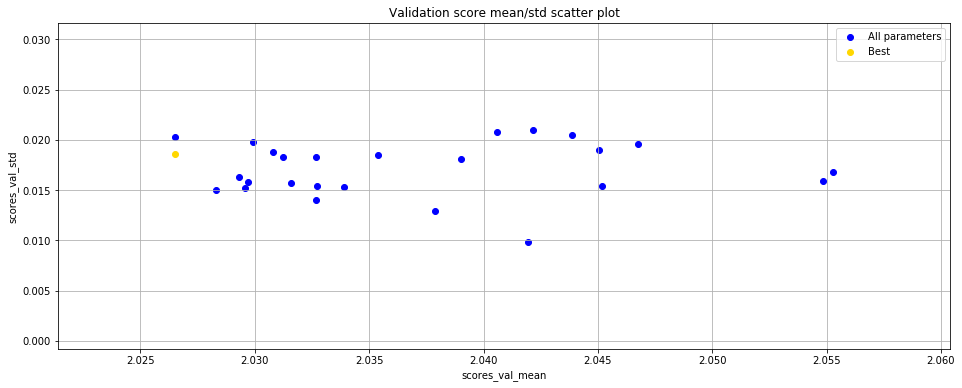

In [296]:
plt.figure(figsize=(16, 6))
plt.scatter(scores_val_mean, scores_val_std, color='blue')
plt.scatter(best_score, best_score_std, color='gold')
plt.xlim([2, 3])
plt.ylim([0, 0.1])
plt.xlabel('scores_val_mean')
plt.ylabel('scores_val_std')
plt.title('Validation score mean/std scatter plot')
plt.grid()
plt.legend(['All parameters', 'Best'])
plt.show()

In [224]:
print(f"best_score={best_score}")

best_score=2.0486678000000005


In [225]:
best_params

{'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 6,
 'nthread': 32,
 'objective': 'reg:linear',
 'silent': True,
 'subsample': 0.5}

Fold 0 started at Mon Mar 25 07:23:59 2019
[0]	train-mae:5.14353	valid_data-mae:5.12489
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[252]	train-mae:1.57684	valid_data-mae:2.03898

Fold 1 started at Mon Mar 25 07:24:01 2019
[0]	train-mae:5.1654	valid_data-mae:5.03932
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[291]	train-mae:1.52709	valid_data-mae:2.03496

Fold 2 started at Mon Mar 25 07:24:03 2019
[0]	train-mae:5.11568	valid_data-mae:5.24081
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:1.26967	valid_data-mae:2.15704
Stopping. Best iteration:
[326]	train-mae:1.45431	valid_data-mae:2.15065

Fold 3

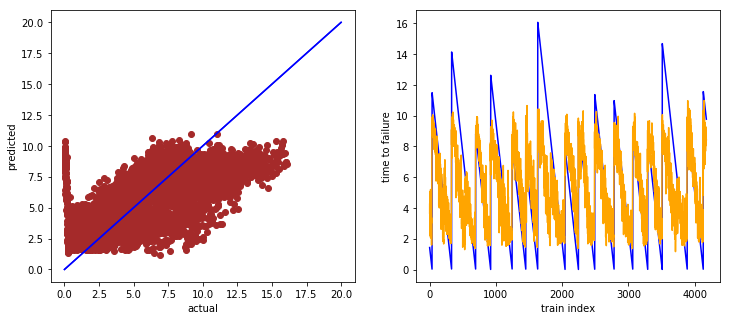

In [699]:
xgb_params = {
    'eta': 0.01, #Andrew uses 0.03
    'max_depth': 6, #Andrew uses 10
    'subsample': 0.5, #Andrew uses 0.9
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
} # CV mean score: 2.0801, std: 0.0711.
oof_xgb, prediction_xgb, score_mean_xgb, score_std_xgb = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=xgb_params,
                                                                     model_type='xgb',
                                                                     show_scatter=True)

### SVM
Similar to NuSVC, for regression, uses a parameter nu to control the number of support vectors. However, unlike NuSVC, where nu replaces C, here nu replaces the parameter epsilon of epsilon-SVR.

Let's first search for the best parameters ($\nu$ and $C$) for this model using `GridSearchCV`.

In [40]:
grid = [{'nu': np.linspace(0.15, 0.99, 50),
         'C': np.linspace(0.15, 5, 50)}]

In [41]:
target = y_tr.values.flatten()
params, cv_results = grid_search_cv(NuSVR(gamma='scale', tol=0.01), grid, X_train_scaled_best, target, n_fold_models)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 10304 tasks      | elapsed: 99.8min
[Parallel(n_jobs=-1)]: Done 10449 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 10594 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 10741 tasks      | elapsed: 104.4min
[Parallel(n_jobs=-1)]: Done 10888 tasks      | elapsed: 105.6min
[Parallel(n_jobs=-1)]: Done 11037 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 108.8min
[Parallel(n_jobs=-1)]: Done 11337 tasks      | elapsed: 110.1min
[Parallel(n_jobs=-1)]: Done 11488 tasks      | elapsed: 112.0min
[Parallel(n_jobs=-1)]: Done 11641 tasks      | elapsed: 113.2min
[Parallel(n_jobs=-1)]: Done 11794 tasks      | elapsed: 114.8min
[Parallel(n_jobs=-1)]: Done 11949 tasks      | elapsed: 116.6min
[Parallel(n_jobs=-1)]: Done 12104 tasks      | elapsed: 117.9min
[Parallel(n_jobs=-1)]: Done 12261 tasks      | elapsed: 119.7min
[Parallel(n_jobs=-1)]: Done 12418 tasks      | elapsed: 121.2min
[Parallel(n_jobs=-1)]: Don

Best CV score: 2.1167, time: 7332.8s
{'C': 0.4469387755102041, 'nu': 0.63}


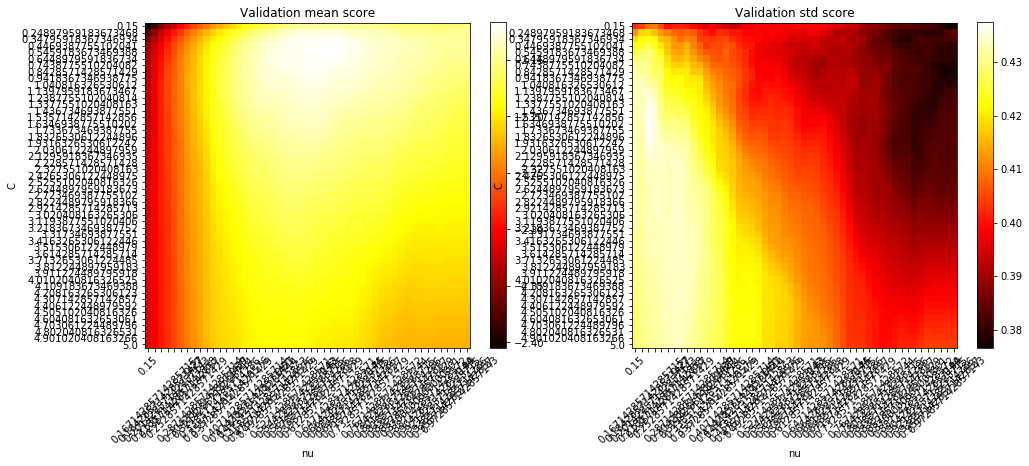

In [42]:
scores_mean = cv_results['mean_test_score'].reshape(len(grid[0]['nu']), len(grid[0]['C']))
scores_std = cv_results['std_test_score'].reshape(len(grid[0]['nu']), len(grid[0]['C']))

plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(scores_mean, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('nu')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(grid[0]['nu'])), grid[0]['nu'], rotation=45)
plt.yticks(np.arange(len(grid[0]['C'])), grid[0]['C'])
plt.title('Validation mean score')

plt.subplot(1, 2, 2)
plt.imshow(scores_std, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('nu')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(grid[0]['nu'])), grid[0]['nu'], rotation=45)
plt.yticks(np.arange(len(grid[0]['C'])), grid[0]['C'])
plt.title('Validation std score')
plt.show()

Now, we can put the best parameters in builidng the model.

In [43]:
params

{'C': 0.4469387755102041, 'nu': 0.63}

Fold 0 started at Mon Mar 25 07:24:09 2019
Fold 0. MAE: 2.0524.

Fold 1 started at Mon Mar 25 07:24:11 2019
Fold 1. MAE: 2.1063.

Fold 2 started at Mon Mar 25 07:24:14 2019
Fold 2. MAE: 2.1487.

Fold 3 started at Mon Mar 25 07:24:17 2019
Fold 3. MAE: 1.9608.

Fold 4 started at Mon Mar 25 07:24:20 2019
Fold 4. MAE: 2.0751.

CV mean score: 2.0687, std: 0.0629.


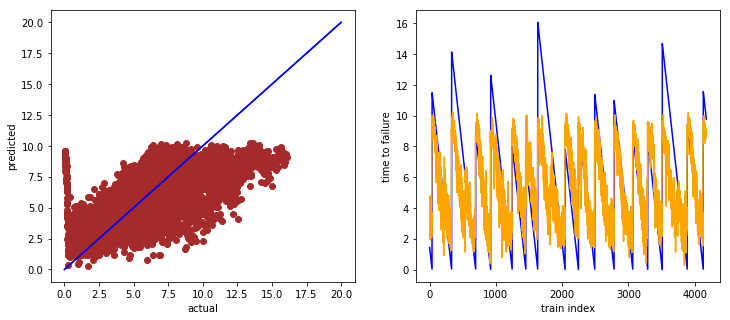

In [700]:
#model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01) #original values
model = NuSVR(gamma='scale', nu=0.63, C=0.4469387755102041, tol=0.01)
oof_svr, prediction_svr, score_mean_svr, score_std_svr = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=None,
                                                                     model_type='sklearn',
                                                                     model=model,
                                                                     show_scatter=True)

### Catboost

Fold 0 started at Mon Mar 25 07:35:48 2019


Fold 1 started at Mon Mar 25 07:39:02 2019


Fold 2 started at Mon Mar 25 07:42:13 2019


Fold 3 started at Mon Mar 25 07:45:44 2019


Fold 4 started at Mon Mar 25 07:49:14 2019


CV mean score: 2.0245, std: 0.0766.


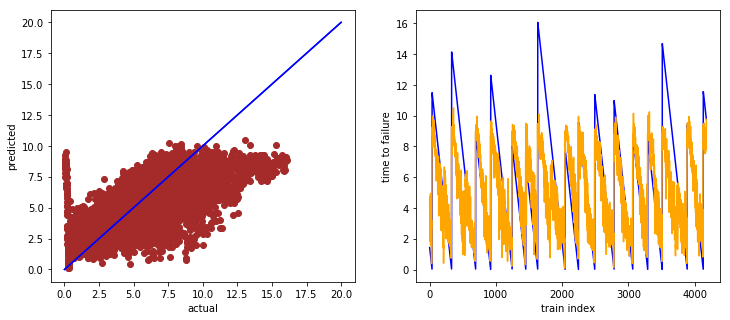

In [702]:
cat_params = {
    'loss_function':'MAE'
}
oof_cat, prediction_cat, score_mean_cat, score_std_cat = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=cat_params,
                                                                     model_type='cat',
                                                                     show_scatter=True)

### Kernel Ridge
This model combines regularized linear regression with a given kernel (radial basis in this case).

Let's first search for the best parameters ($\alpha$ and $\gamma$) for this model using `GridSearchCV`.

In [46]:
grid = [{
    'alpha': np.linspace(0.001, 10, 50),
    'gamma': np.linspace(0.00001, 0.03, 50)
}]

In [47]:
target = y_tr.values.flatten()
params, cv_results = grid_search_cv(KernelRidge(kernel='rbf'), grid, X_train_scaled_best, target, n_fold_models)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 10018 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 10161 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 10304 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 10449 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 10594 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 10741 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 10888 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 11037 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 47.8min
[Parallel(n_jobs=-1)]: Done 11337 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done 11488 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 11641 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 11794 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 11949 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 12104 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 12261 tasks 

Best CV score: 2.1283, time: 3203.4s
{'alpha': 2.4497346938775513, 'gamma': 0.0018461224489795917}


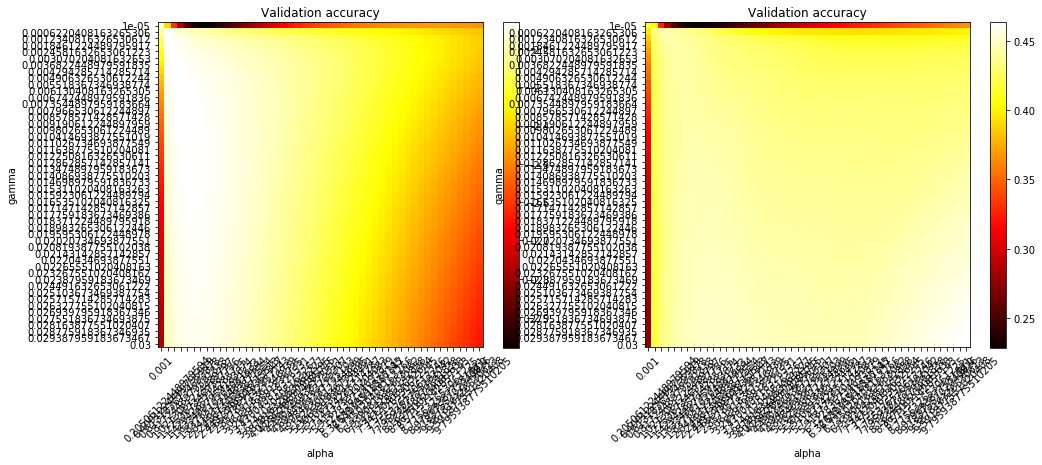

In [48]:
scores_mean = cv_results['mean_test_score'].reshape(len(grid[0]['alpha']), len(grid[0]['gamma']))
scores_std = cv_results['std_test_score'].reshape(len(grid[0]['alpha']), len(grid[0]['gamma']))

plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(scores_mean, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('alpha')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(grid[0]['alpha'])), grid[0]['alpha'], rotation=45)
plt.yticks(np.arange(len(grid[0]['gamma'])), grid[0]['gamma'])
plt.title('Validation accuracy')

plt.subplot(1, 2, 2)
plt.imshow(scores_std, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('alpha')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(grid[0]['alpha'])), grid[0]['alpha'], rotation=45)
plt.yticks(np.arange(len(grid[0]['gamma'])), grid[0]['gamma'])
plt.title('Validation accuracy')
plt.show()

In [49]:
params

{'alpha': 2.4497346938775513, 'gamma': 0.0018461224489795917}

Now, we can put the best parameters in builidng the model.

Fold 0 started at Mon Mar 25 07:52:56 2019
Fold 0. MAE: 2.0724.

Fold 1 started at Mon Mar 25 07:52:57 2019
Fold 1. MAE: 2.0736.

Fold 2 started at Mon Mar 25 07:52:58 2019
Fold 2. MAE: 2.1609.

Fold 3 started at Mon Mar 25 07:52:59 2019
Fold 3. MAE: 1.9481.

Fold 4 started at Mon Mar 25 07:53:00 2019
Fold 4. MAE: 2.0996.

CV mean score: 2.0709, std: 0.0693.


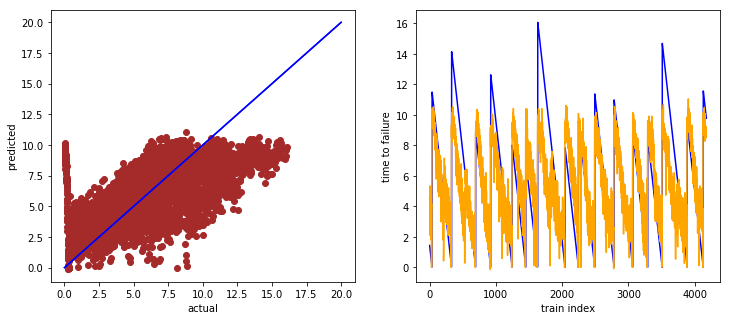

In [703]:
#model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01) #Original parameters
model = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
oof_r, prediction_r, score_mean_r, score_std_r = train_model(X=X_train_scaled_best,
                                                             X_test=X_test_scaled_best,
                                                             y=y_tr,
                                                             folds=folds_models,
                                                             params=None,
                                                             model_type='sklearn',
                                                             model=model,
                                                             show_scatter=True)

### Genetic Program Model
Genetic programming model from https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model

Fold 0 started at Mon Mar 25 07:53:01 2019
Fold 1 started at Mon Mar 25 07:53:01 2019
Fold 2 started at Mon Mar 25 07:53:02 2019
Fold 3 started at Mon Mar 25 07:53:02 2019
Fold 4 started at Mon Mar 25 07:53:03 2019
CV mean score: 1.8985, std: 0.0738.


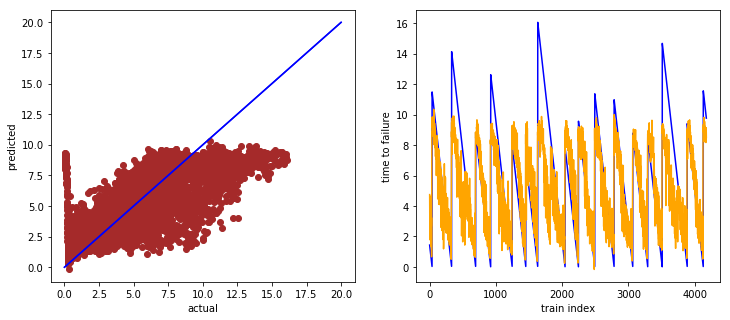

In [704]:
# There are no tuning here. We took at as face value.
oof_gdi, prediction_gdi, score_mean_gdi, score_std_gdi = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     model_type='gdi',
                                                                     show_scatter=True)

### Random Forest
This regressor fits many decision trees with different subsets of the original data and average the predictions between them.

In [419]:
grid = [{
    'max_depth': [8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [2, 4, 8]
}]

In [420]:
target = y_tr.values.flatten()
params, cv_results = grid_search_cv(RandomForestRegressor(criterion='mae', n_estimators=200, n_jobs=-1),
                                    grid,
                                    X_train_scaled_best,
                                    target,
                                    n_fold_models)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed: 68.4min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed: 9

Best CV score: 2.1718, time: 6608.2s
{'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4}


In [422]:
params

{'max_depth': 12,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 4}

Fold 0 started at Mon Mar 25 07:53:04 2019
Fold 0. MAE: 2.0571.

Fold 1 started at Mon Mar 25 07:53:07 2019
Fold 1. MAE: 2.0881.

Fold 2 started at Mon Mar 25 07:53:10 2019
Fold 2. MAE: 2.1293.

Fold 3 started at Mon Mar 25 07:53:14 2019
Fold 3. MAE: 1.9294.

Fold 4 started at Mon Mar 25 07:53:17 2019
Fold 4. MAE: 2.0783.

CV mean score: 2.0564, std: 0.0677.


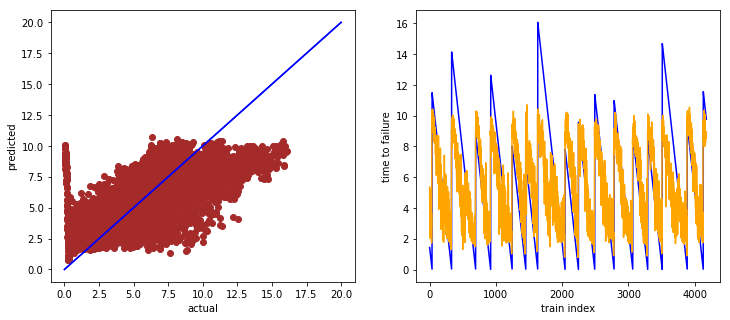

In [705]:
rf_params = {
    'max_depth': 12, #8,
    'max_features': 'log2', #'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 4 #6
} #CV mean score: 2.0448, std: 0.0793.
model = RandomForestRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **rf_params)
oof_rf, prediction_rf, score_mean_rf, score_std_rf = train_model(X=X_train_scaled_best,
                                                                 X_test=X_test_scaled_best,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=rf_params,
                                                                 model_type='sklearn',
                                                                 model=model,
                                                                 show_scatter=True)

### Extremely Randomized Trees


In [408]:
grid = [{
    'max_depth': [5, 8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [2, 4, 8, 16]
}]

In [409]:
target = y_tr.values.flatten()
params, cv_results = grid_search_cv(ExtraTreesRegressor(criterion='mae', n_estimators=200, n_jobs=-1),
                                    grid,
                                    X_train_scaled_best,
                                    target,
                                    n_fold_models)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min


KeyboardInterrupt: 

In [ ]:
params

Fold 0 started at Mon Mar 25 07:54:17 2019
Fold 0. MAE: 2.0402.

Fold 1 started at Mon Mar 25 07:54:21 2019
Fold 1. MAE: 2.0826.

Fold 2 started at Mon Mar 25 07:54:25 2019
Fold 2. MAE: 2.1089.

Fold 3 started at Mon Mar 25 07:54:30 2019
Fold 3. MAE: 1.9247.

Fold 4 started at Mon Mar 25 07:54:34 2019
Fold 4. MAE: 2.0793.

CV mean score: 2.0471, std: 0.0650.


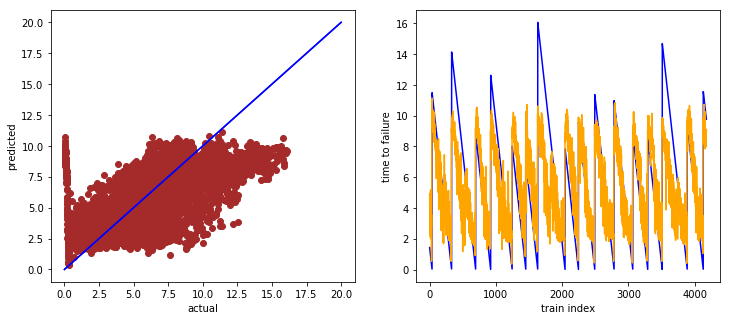

In [706]:
ex_params = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4
}
model = ExtraTreesRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **ex_params)
oof_ex, prediction_ex, score_mean_ex, score_std_ex = train_model(X=X_train_scaled_best,
                                                                 X_test=X_test_scaled_best,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=ex_params,
                                                                 model_type='sklearn',
                                                                 model=model,
                                                                 show_scatter=True)

### Ada Boost
AdaBoost begins by fitting a base estimator on the original dataset and then fits additional copies on the same dataset. At each iteration (estimator), the weights of instances are adjusted according to the error of the last prediction. It's similar to the next model, but gradient boosting fits additional estimator copies on the current error and not on the original dataset.

In [ ]:
grid = [{
    'learning_rate': np.linspace(0.0001, 0.1, 5)
}]
#base = Ridge(alpha=10)
base = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
params = grid_search_cv(AdaBoostRegressor(base_estimator=base, n_estimators=100),
                        grid,
                        X_train_scaled,
                        target,
                        n_fold_models)


In [432]:
params

({'learning_rate': 0.0001},
 {'mean_fit_time': array([622.81377869, 607.2781414 , 614.55447564, 601.15981746,
         518.69998765]),
  'mean_score_time': array([69.65627046, 69.04261355, 67.41252379, 71.17069244, 30.39442735]),
  'mean_test_score': array([-2.12812762, -2.14399884, -2.15921011, -2.16294839, -2.16706735]),
  'mean_train_score': array([-2.01633285, -2.0344927 , -2.0505665 , -2.05975869, -2.06191019]),
  'param_learning_rate': masked_array(data=[0.0001, 0.025075, 0.050050000000000004,
                     0.07502500000000001, 0.1],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.0001},
   {'learning_rate': 0.025075},
   {'learning_rate': 0.050050000000000004},
   {'learning_rate': 0.07502500000000001},
   {'learning_rate': 0.1}],
  'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32),
  'split0_test_score': array([-2.029159  , -2.03492885, -2.05797834, -2.06198193, -2.067138

Fold 0 started at Mon Mar 25 08:58:35 2019
Fold 0. MAE: 2.0761.

Fold 1 started at Mon Mar 25 09:00:32 2019
Fold 1. MAE: 2.0726.

Fold 2 started at Mon Mar 25 09:02:23 2019
Fold 2. MAE: 2.1621.

Fold 3 started at Mon Mar 25 09:04:15 2019
Fold 4. MAE: 2.0994.

CV mean score: 2.0717, std: 0.0695.


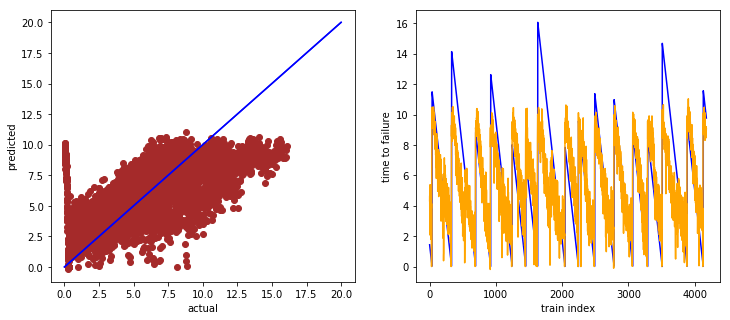

In [707]:
ada_params = {
    'learning_rate': 0.001
}
model = AdaBoostRegressor(base_estimator=base, n_estimators=100, **ada_params)
oof_ada, prediction_ada, score_mean_ada, score_std_ada = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=ada_params,
                                                                     model_type='sklearn',
                                                                     model=model,
                                                                     show_scatter=True)

### NeuralNet
This is a simple FC model mimiquing the previous genetic algorithm.

In [762]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        else:
            print('.', end='')

In [763]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    plt.grid()
    plt.show()

In [751]:
param_grid = {
    'dropout': [0.4, 0.5, 0.7, 0.8, 0.9],
    'num_layers' : [2, 4, 6],
    'num_neurons' : [64, 128, 256]
}
grid = ParameterGrid(param_grid)
results_nn = pd.DataFrame(columns=['dropout', 'num_layers', 'num_neurons', 'val_score'])

for params in tqdm_notebook(grid):
    dropout = params['dropout']
    num_layers = params['num_layers']
    num_neurons = params['num_neurons']
    print(f"Training model with {params}")
    model = Sequential()
    model.add(layers.Dense(1024, input_dim=216, activation=tf.nn.relu))
    model.add(layers.Dropout(dropout))
    for l in range(num_layers):
        model.add(layers.Dense(num_neurons, input_dim=216, activation=tf.nn.relu))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    EPOCHS = 1000
    early_stop = callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
    history = model.fit(
        X_train_scaled_best,
        y_tr,
        epochs=EPOCHS,
        validation_split=0.5,
        verbose=0,
        callbacks=[early_stop, PrintDot()])
    hist = pd.DataFrame(history.history)
    val_score = hist['val_mean_absolute_error'].iloc[-1]
    print(f'val_score={val_score}')
    plot_history(history)

    results_nn = results_nn.append({'dropout': dropout,
                                    'num_layers' : num_layers,
                                    'num_neurons' : num_neurons,
                                    'val_score' : val_score},
                                   ignore_index=True)
    

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

Training model with {'dropout': 0.4, 'num_layers': 2, 'num_neurons': 64}


KeyboardInterrupt: 

In [690]:
results_nn

,dropout,num_layers,num_neurons,val_score
0,0.4,2.0,64.0,2.010804012382128
1,0.4,2.0,128.0,2.082967808510254
2,0.4,2.0,256.0,2.081518015261185
3,0.4,4.0,64.0,2.727398404668769
4,0.4,4.0,128.0,2.102146659529683
5,0.4,4.0,256.0,2.455143035057346
6,0.4,6.0,64.0,3.160447767558082
7,0.4,6.0,128.0,2.257560949453388
8,0.4,6.0,256.0,2.331547454962495
9,0.5,2.0,64.0,2.091549712542200


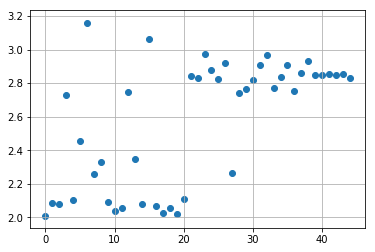

In [691]:
plt.figure()
plt.scatter(results_nn.index, results_nn['val_score'])
plt.grid()

In [794]:
del model

NameError: name 'model' is not defined

In [827]:
sess = backend.get_session()
sess.close()
backend.clear_session()
gc.collect()
tf.keras.backend.clear_session()
sess = tf.keras.backend.get_session()
sess.close()
gc.collect()

106

In [828]:
dropout = 0.4
num_layers = 3
num_neurons = 64
model = Sequential()
model.add(layers.Dense(1024, input_dim=216, activation=tf.nn.relu))
model.add(layers.Dropout(dropout))
for l in range(num_layers):
    model.add(layers.Dense(num_neurons, input_dim=216, activation=tf.nn.relu))
    model.add(layers.Dropout(dropout))
model.add(layers.Dense(1))

model = multi_gpu_model(model, gpus=2, cpu_merge=False)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
EPOCHS = 1000
early_stop = callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
history = model.fit(
    X_train_scaled_best,
    y_tr,
    validation_split=0.5,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stop, PrintDot()])
hist = pd.DataFrame(history.history)
val_score = hist['val_mean_absolute_error'].iloc[-1]
print(f'val_score={val_score}')
plot_history(history)

results_nn = results_nn.append({'dropout': dropout,
                                'num_layers' : num_layers,
                                'num_neurons' : num_neurons,
                                'val_score' : val_score},
                               ignore_index=True)


..........................................................................

KeyboardInterrupt: 

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
        
ax1.scatter(y_tr, oof_nn, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(oof_nn, color='orange')


Fold 0 started at Sat Mar 23 10:11:17 2019

...................................................................................................
...................................................................................................
................................................................val_score=2.107083411878376


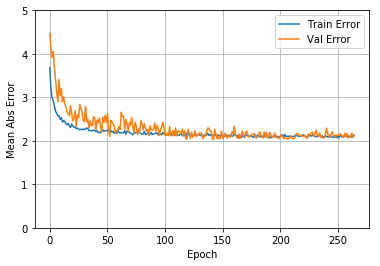

Fold 0. MAE: 2.1071.
Fold 1 started at Sat Mar 23 10:13:22 2019

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
.................................................................val_score=2.3368129159845235


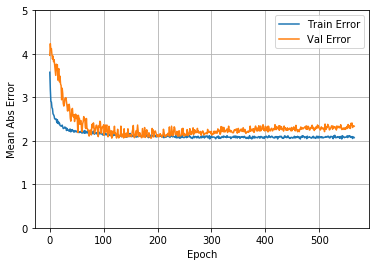

Fold 1. MAE: 2.3368.
Fold 2 started at Sat Mar 23 10:17:48 2019

...................................................................................................
...................................................................................................
................

KeyboardInterrupt: 

In [546]:
oof_nn, prediction_nn, score_mean_nn, score_std_nn = train_model(X=X_train_scaled_best,
                                                                 X_test=X_test_scaled_best,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=params,
                                                                 model_type='nn',
                                                                 show_scatter=True)

## Stacking and blending
And now let's try stacking :) We can use the same function for it.

In [708]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_r, oof_cat, oof_gdi, oof_rf, oof_ex,
                         oof_ada]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'r', 'cat', 'gdi', 'rf', 'ex', 'ada'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_r,
                        prediction_cat, prediction_gdi, prediction_rf, prediction_ex, prediction_ada]).transpose()
test_stack = pd.DataFrame(test_stack)

In [709]:
fixed_params = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'n_estimators': 50000,
    'metric': 'mae',
    'bagging_seed': 11
}

In [493]:
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)
}

In [494]:
best_score = 9999
dataset = lgb.Dataset(train_stack, label=y_tr)  # no need to scale features

scores_val_mean = []
scores_val_std = []
for i in tqdm_notebook(range(200)):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params,
                    dataset,
                    nfold=n_fold_models,
                    early_stopping_rounds=200,
                    stratified=False)
    
    print(f"Iteration {i} finished with mae={result['l1-mean'][-1]:.4f} and std={result['l1-stdv'][-1]:.4f}")
    scores_val_mean.append(result['l1-mean'][-1])
    scores_val_std.append(result['l1-stdv'][-1])
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

Iteration 0 finished with mae=1.8649 and std=0.0243
Iteration 1 finished with mae=1.8639 and std=0.0236
Iteration 2 finished with mae=1.8839 and std=0.0242
Iteration 3 finished with mae=1.8677 and std=0.0221
Iteration 4 finished with mae=1.8927 and std=0.0280
Iteration 5 finished with mae=1.8751 and std=0.0211
Iteration 6 finished with mae=1.8906 and std=0.0291
Iteration 7 finished with mae=1.8830 and std=0.0243
Iteration 8 finished with mae=1.8750 and std=0.0301
Iteration 9 finished with mae=1.8640 and std=0.0265
Iteration 10 finished with mae=1.8747 and std=0.0238
Iteration 11 finished with mae=1.8627 and std=0.0246
Iteration 12 finished with mae=1.8678 and std=0.0227
Iteration 13 finished with mae=1.8947 and std=0.0294
Iteration 14 finished with mae=1.8771 and std=0.0268
Iteration 15 finished with mae=1.9085 and std=0.0299
Iteration 16 finished with mae=1.8678 and std=0.0232
Iteration 17 finished with mae=1.8717 and std=0.0264
Iteration 18 finished with mae=1.8696 and std=0.0211
Ite

Iteration 154 finished with mae=1.8611 and std=0.0203
Iteration 155 finished with mae=1.8929 and std=0.0285
Iteration 156 finished with mae=1.8670 and std=0.0230
Iteration 157 finished with mae=1.8902 and std=0.0272
Iteration 158 finished with mae=1.8656 and std=0.0261
Iteration 159 finished with mae=1.8662 and std=0.0252
Iteration 160 finished with mae=1.8636 and std=0.0248
Iteration 161 finished with mae=1.8648 and std=0.0226
Iteration 162 finished with mae=1.8676 and std=0.0259
Iteration 163 finished with mae=1.8700 and std=0.0238
Iteration 164 finished with mae=1.8831 and std=0.0245
Iteration 165 finished with mae=1.8831 and std=0.0287
Iteration 166 finished with mae=1.8706 and std=0.0228
Iteration 167 finished with mae=1.8649 and std=0.0244
Iteration 168 finished with mae=1.8693 and std=0.0244
Iteration 169 finished with mae=1.8846 and std=0.0184
Iteration 170 finished with mae=1.8990 and std=0.0310
Iteration 171 finished with mae=1.8609 and std=0.0198
Iteration 172 finished with 

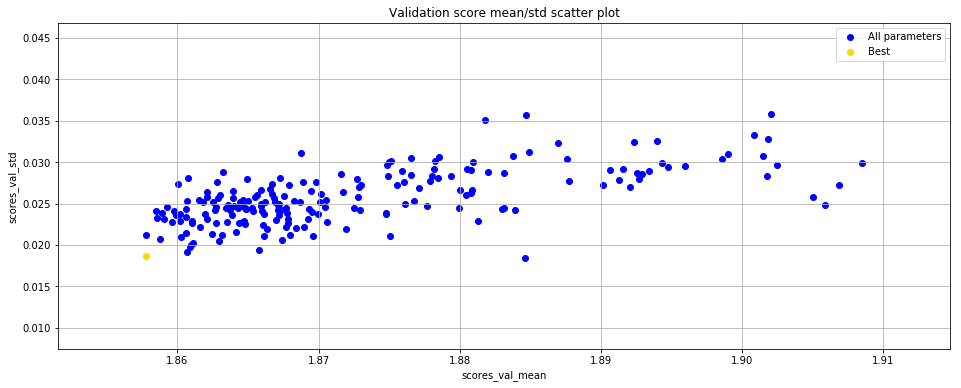

In [495]:
plt.figure(figsize=(16, 6))
plt.scatter(scores_val_mean, scores_val_std, color='blue')
plt.scatter(best_score, best_score_std, color='gold')
plt.xlabel('scores_val_mean')
plt.ylabel('scores_val_std')
plt.title('Validation score mean/std scatter plot')
plt.grid()
plt.legend(['All parameters', 'Best'])
plt.show()

In [496]:
print(f"best_score={best_score}")

best_score=1.857749558528236


In [497]:
best_params

{'bagging_fraction': 0.7555555555555555,
 'bagging_freq': 5,
 'bagging_seed': 11,
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 5,
 'metric': 'mae',
 'min_data_in_leaf': 100,
 'n_estimators': 50000,
 'num_leaves': 8,
 'objective': 'huber',
 'random_seed': 19,
 'reg_alpha': 0.95,
 'reg_lambda': 0.19444444444444445,
 'verbosity': -1}

In [710]:
params = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 8, #54,
    'min_data_in_leaf': 100, #79,
    'max_depth': 5, #-1,
    'learning_rate': 0.01, #0.01,
    'bagging_freq': 5, #5,
    'bagging_fraction': 0.7555555555555555, #0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'reg_alpha': 0.95, #0.1302650970728192,
    'reg_lambda': 0.19444444444444445 #0.3603427518866501
}
oof_lgb_stack, prediction_lgb_stack, score_mean_stack, score_std_stack, feature_importance = train_model(
    X=train_stack,
    X_test=test_stack,
    y=y_tr,
    folds=folds_models,
    params=params,
    model_type='lgb')

Fold 0 started at Mon Mar 25 09:07:59 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1625]	training's l1: 1.76934	valid_1's l1: 1.87657
Fold 1 started at Mon Mar 25 09:08:02 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2545]	training's l1: 1.74624	valid_1's l1: 1.85098
Fold 2 started at Mon Mar 25 09:08:07 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1850]	training's l1: 1.74011	valid_1's l1: 1.94814
Fold 3 started at Mon Mar 25 09:08:11 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1858]	training's l1: 1.79604	valid_1's l1: 1.73084
Fold 4 started at Mon Mar 25 09:08:14 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1840]	training's l1: 1.76666	valid_1's l1: 1.87151
CV mean score: 1.8556, std: 0.

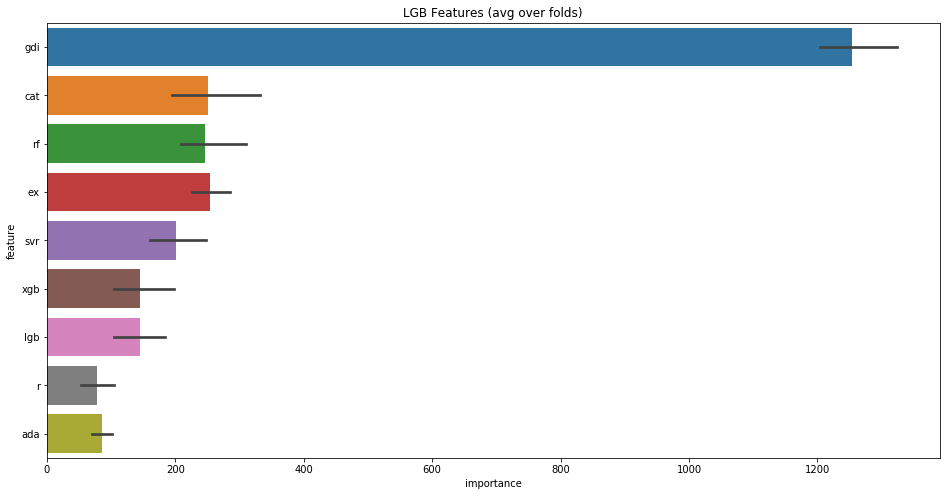

In [711]:
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(16, 8));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

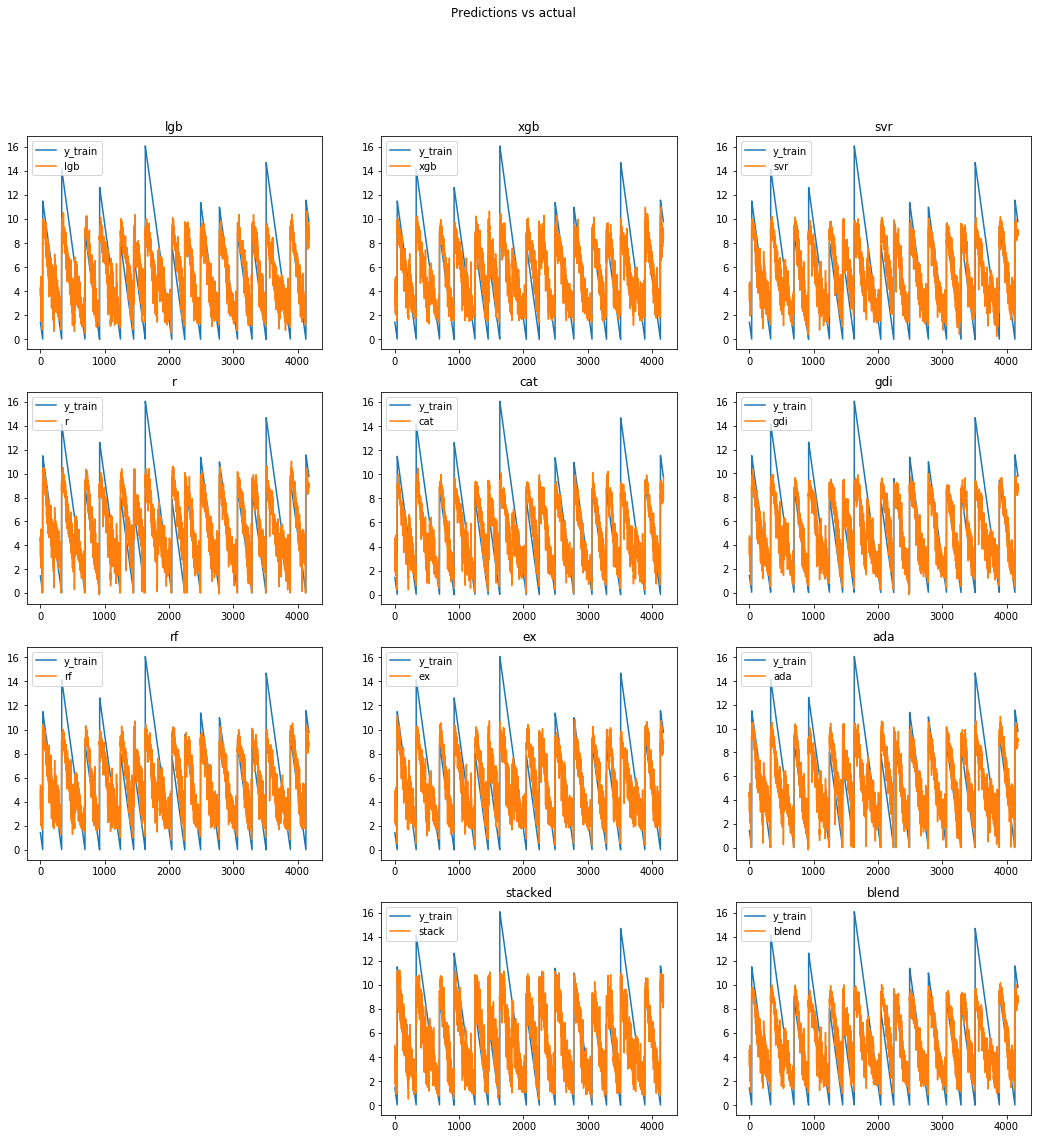

In [712]:
plt.figure(figsize=(18, 18))
plt.subplot(4, 3, 1)
plt.plot(y_tr, label='y_train')
plt.plot(oof_lgb, label='lgb')
plt.legend()
plt.title('lgb');

plt.subplot(4, 3, 2)
plt.plot(y_tr, label='y_train')
plt.plot(oof_xgb, label='xgb')
plt.legend()
plt.title('xgb');

plt.subplot(4, 3, 3)
plt.plot(y_tr, label='y_train')
plt.plot(oof_svr, label='svr')
plt.legend()
plt.title('svr');

plt.subplot(4, 3, 4)
plt.plot(y_tr, label='y_train')
plt.plot(oof_r, label='r')
plt.legend()
plt.title('r');

plt.subplot(4, 3, 5)
plt.plot(y_tr, label='y_train')
plt.plot(oof_cat, label='cat')
plt.legend()
plt.title('cat');

plt.subplot(4, 3, 6)
plt.plot(y_tr, label='y_train')
plt.plot(oof_gdi, label='gdi')
plt.legend()
plt.title('gdi');

plt.subplot(4, 3, 7)
plt.plot(y_tr, label='y_train')
plt.plot(oof_rf, label='rf')
plt.legend()
plt.title('rf');

plt.subplot(4, 3, 8)
plt.plot(y_tr, label='y_train')
plt.plot(oof_ex, label='ex')
plt.legend()
plt.title('ex');

plt.subplot(4, 3, 9)
plt.plot(y_tr, label='y_train')
plt.plot(oof_ada, label='ada')
plt.legend()
plt.title('ada');

plt.subplot(4, 3, 11)
plt.plot(y_tr, label='y_train')
plt.plot(oof_lgb_stack, label='stack')
plt.legend()
plt.title('stacked');

plt.subplot(4, 3, 12)
plt.plot(y_tr, label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_r + oof_cat + oof_gdi + oof_rf + oof_ex + oof_ada) / 9, label='blend')
plt.legend()
plt.title('blend');
plt.suptitle('Predictions vs actual');

### Submission - Blend model

In [713]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr
                                + prediction_cat + prediction_r + prediction_gdi
                                + prediction_rf + prediction_ex + prediction_ada) / 9
submission.to_csv('../output/submission_rdg_notebook3_blend.csv')
score_mean_blend = (score_mean_lgb + score_mean_xgb + score_mean_svr + score_mean_cat
                    + score_mean_r + score_mean_gdi + score_mean_rf + score_mean_ex + score_mean_ada) / 9
score_std_blend = (score_std_lgb + score_std_xgb + score_std_svr + score_std_cat
                    + score_std_r + score_std_gdi + score_std_rf + score_std_ex + score_std_ada) / 9
print(f'CV mean score: {score_mean_blend:.4f}, std: {score_std_blend:.4f}.')

CV mean score: 2.0343, std: 0.0705.


### Submission - Stacked model

In [714]:
submission['time_to_failure'] = prediction_lgb_stack
submission.to_csv('../output/submission_rdg_notebook3_stack.csv')
print(f'CV mean score: {score_mean_stack:.4f}, std: {score_std_stack:.4f}.')

CV mean score: 1.8556, std: 0.0705.


### Submission - LGB model

In [715]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('../output/submission_rdg_notebook3_lgb.csv')
print(f'CV mean score: {score_mean_lgb:.4f}, std: {score_std_lgb:.4f}.')

CV mean score: 2.0244, std: 0.0769.


### Submission - XGB model

In [716]:
submission['time_to_failure'] = prediction_xgb
submission.to_csv('../output/submission_rdg_notebook3_xgb.csv')
print(f'CV mean score: {score_mean_xgb:.4f}, std: {score_std_xgb:.4f}.')

CV mean score: 2.0466, std: 0.0728.


### Submission - SVR model

In [717]:
submission['time_to_failure'] = prediction_svr
submission.to_csv('../output/submission_rdg_notebook3_svr.csv')
print(f'CV mean score: {score_mean_svr:.4f}, std: {score_std_svr:.4f}.')

CV mean score: 2.0687, std: 0.0629.


### Submission - CAT model

In [718]:
submission['time_to_failure'] = prediction_cat
submission.to_csv('../output/submission_rdg_notebook3_cat.csv')
print(f'CV mean score: {score_mean_cat:.4f}, std: {score_std_cat:.4f}.')

CV mean score: 2.0245, std: 0.0766.


### Submission - R model

In [719]:
submission['time_to_failure'] = prediction_r
submission.to_csv('../output/submission_rdg_notebook3_r.csv')
print(f'CV mean score: {score_mean_r:.4f}, std: {score_std_r:.4f}.')

CV mean score: 2.0709, std: 0.0693.


### Submission - GDI model

In [720]:
submission['time_to_failure'] = prediction_gdi
submission.to_csv('../output/submission_rdg_notebook3_gdi.csv')
print(f'CV mean score: {score_mean_gdi:.4f}, std: {score_std_gdi:.4f}.')

CV mean score: 1.8985, std: 0.0738.


### Submission - RF model

In [721]:
submission['time_to_failure'] = prediction_rf
submission.to_csv('../output/submission_rdg_notebook3_rf.csv')
print(f'CV mean score: {score_mean_rf:.4f}, std: {score_std_rf:.4f}.')

CV mean score: 2.0564, std: 0.0677.


### Submission - EX model

In [722]:
submission['time_to_failure'] = prediction_ex
submission.to_csv('../output/submission_rdg_notebook3_ex.csv')
print(f'CV mean score: {score_mean_ex:.4f}, std: {score_std_ex:.4f}.')

CV mean score: 2.0471, std: 0.0650.


### Submission - ADA model

In [723]:
submission['time_to_failure'] = prediction_ada
submission.to_csv('../output/submission_rdg_notebook3_ada.csv')
print(f'CV mean score: {score_mean_ada:.4f}, std: {score_std_ada:.4f}.')

CV mean score: 2.0717, std: 0.0695.


## Models overview

In [724]:
evaluation = pd.DataFrame(dtype=np.float64)

In [725]:
evaluation.loc['lgb', 'mean'] = score_mean_lgb
evaluation.loc['lgb', 'std'] = score_std_lgb

evaluation.loc['xgb', 'mean'] = score_mean_xgb
evaluation.loc['xgb', 'std'] = score_std_xgb

evaluation.loc['svr', 'mean'] = score_mean_svr
evaluation.loc['svr', 'std'] = score_std_svr

evaluation.loc['cat', 'mean'] = score_mean_cat
evaluation.loc['cat', 'std'] = score_std_cat

evaluation.loc['r', 'mean'] = score_mean_r
evaluation.loc['r', 'std'] = score_std_r

evaluation.loc['gdi', 'mean'] = score_mean_gdi
evaluation.loc['gdi', 'std'] = score_std_gdi

evaluation.loc['rf', 'mean'] = score_mean_rf
evaluation.loc['rf', 'std'] = score_std_rf

evaluation.loc['ex', 'mean'] = score_mean_ex
evaluation.loc['ex', 'std'] = score_std_ex

evaluation.loc['ada', 'mean'] = score_mean_ada
evaluation.loc['ada', 'std'] = score_std_ada

evaluation.loc['blend', 'mean'] = score_mean_blend
evaluation.loc['blend', 'std'] = score_std_blend

evaluation.loc['stack', 'mean'] = score_mean_stack
evaluation.loc['stack', 'std'] = score_std_stack

In [726]:
evaluation

,mean,std
lgb,2.024352220055881,0.076917205307755
xgb,2.046574976278305,0.072752873924825
svr,2.068670598988593,0.062860511696201
cat,2.024486835185205,0.076578695119809
r,2.070936551197323,0.069297627971490
gdi,1.898540917950370,0.073752849335920
rf,2.056448393690532,0.067698667082293
ex,2.047128292830856,0.065022605957494
ada,2.071744143005377,0.069509379541823
blend,2.034320325464716,0.070487823993068


In [727]:

evaluation.to_csv(f"../output/evaluation_{str(datetime.datetime.now())}.csv")

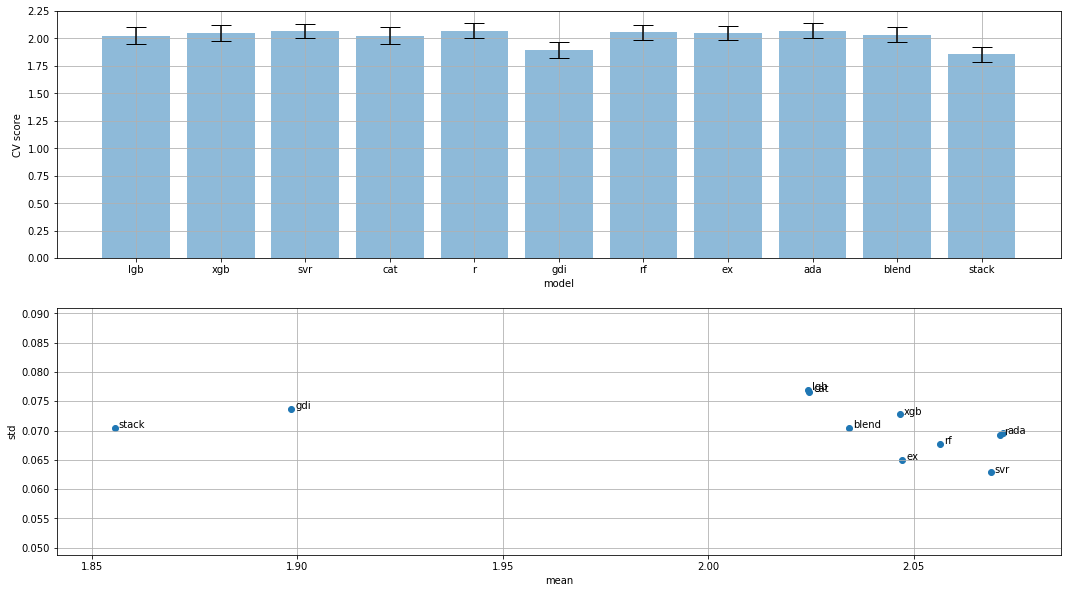

In [728]:
plt.subplots(figsize=(18, 10))
plt.subplot(2, 1, 1)
plt.bar(np.arange(len(evaluation.index.tolist())), evaluation['mean'], yerr=evaluation['std'], align='center',
       alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('CV score')
plt.xlabel('model')
plt.xticks(np.arange(len(evaluation.index.tolist())), evaluation.index.tolist())
plt.grid()

plt.subplot(2, 1, 2)
plt.scatter(evaluation['mean'], evaluation['std'])

model_list = evaluation.index.tolist()
score_mean_list = evaluation['mean'].tolist()
score_std_list = evaluation['std'].tolist()

for i in range(len(model_list)):
    plt.annotate(model_list[i], (score_mean_list[i]+0.001, score_std_list[i]))
    
plt.ylabel('std')
plt.xlabel('mean')
plt.grid()

plt.show()